# Continous Feature Engineering and Scaling

### Create a new DataSet called 'preprocessed_sales.csv'

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
file_path = 'sales.csv'  # Update the path if needed
data = pd.read_csv(file_path)

# print(data.head(3))

# Ensure the 'date' column is of datetime type
data['date'] = pd.to_datetime(data['date'])

# Dont need the 'year' and 'month' columns based on 'date'

# Drop the 'date' column
columns_to_drop = ['state_holiday', 'school_holiday', 'Unnamed: 0', 'date']
data = data.drop(columns=columns_to_drop)

# Filter only the days when the store was open
data_open = data[data['open'] == 1].reset_index(drop=True)

# Drop the 'open' column as it's no longer needed
data_open = data_open.drop(columns=['open'])

# Print the processed data
print("Processed data (stores open only):")
print(data_open.head())

# Save the preprocessed dataset to a new CSV file
output_file = './data/preprocessed_sales.csv'
data_open.to_csv(output_file, index=False)
print(f"\nPreprocessed dataset saved to '{output_file}'.")

Processed data (stores open only):
   store_ID  day_of_week  nb_customers_on_day  promotion  sales
0       366            4                  517          0   4422
1       394            6                  694          0   8297
2       807            4                  970          1   9729
3       802            2                  473          1   6513
4       726            4                 1068          1  10882

Preprocessed dataset saved to './data/preprocessed_sales.csv'.


# Focus on Outliers

Number of outliers (lower-upper bound): 19365
Number of outliers (z_score): 8437


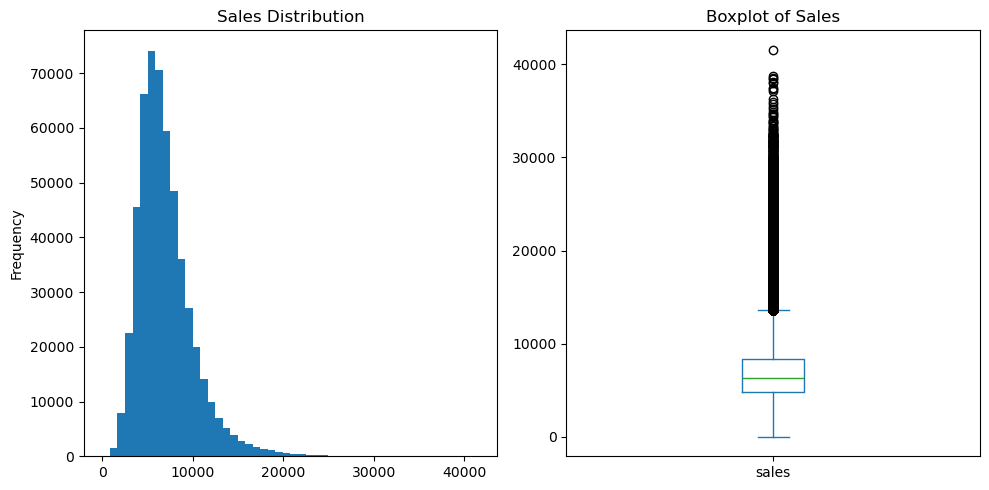

In [60]:
# Load the preprocessed dataset
file_path = './data/preprocessed_sales.csv'  # Update path if needed
data = pd.read_csv(file_path)

Q1 = data['sales'].quantile(0.25)
Q3 = data['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['sales'] < lower_bound) | (data['sales'] > upper_bound)]
print(f"Number of outliers (lower-upper bound): {len(outliers)}")

from scipy.stats import zscore

data['z_score'] = zscore(data['sales'])
outliers = data[data['z_score'].abs() > 3]
print(f"Number of outliers (z_score): {len(outliers)}")
data = data.drop(columns=['z_score'])  # Clean up the added column

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data['sales'].plot(kind='hist', bins=50, title='Sales Distribution')
plt.subplot(1, 2, 2)
data['sales'].plot(kind='box', title='Boxplot of Sales')
plt.tight_layout()
plt.show()

# Remove the z_score Outliers

In [4]:
import pandas as pd
from scipy.stats import zscore

# Load the preprocessed dataset
file_path = './data/preprocessed_sales.csv'  # Update the path if needed
data = pd.read_csv(file_path)

# Calculate the z-scores for the 'sales' column
data['z_score'] = zscore(data['sales'])

# Filter out rows with z-scores greater than 3 or less than -3
data_without_outliers = data[data['z_score'].abs() <= 3].reset_index(drop=True)

# Drop the 'z_score' column as it's no longer needed
data_without_outliers = data_without_outliers.drop(columns=['z_score'])

# Save the dataset without outliers to a new CSV file
output_file = './data/preprocessed_sales_without_outliers.csv'
data_without_outliers.to_csv(output_file, index=False)

# Print summary information
print(f"Original dataset size: {len(data)}")
print(f"Dataset size without outliers: {len(data_without_outliers)}")
print(f"\nDataset without outliers saved to '{output_file}'.")

Original dataset size: 532016
Dataset size without outliers: 523579

Dataset without outliers saved to './data/preprocessed_sales_without_outliers.csv'.


# RandomForestRegressor Model Training

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the preprocessed dataset
# file_path = './data/preprocessed_sales.csv'  # Update path if needed
file_path = './data/preprocessed_sales_without_outliers.csv'  # Update path if needed
data = pd.read_csv(file_path)

# Separate features (X) and target (y)
X = data.drop(columns=['sales'])  # Drop the target variable
y = data['sales']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, 
                                 n_jobs=-1, 
                                 min_samples_leaf=1, 
                                 min_samples_split=5,
                                 n_estimators=300,
                                bootstrap=True,
                                max_depth=None)
# {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Feature importance
feature_importance = rf_model.feature_importances_
important_features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

# Compare predicted values with actual values
exact_matches = np.sum(np.isclose(y_test, y_pred, atol=1e-5))  # Considering floating-point precision
total_test_rows = len(y_test)

# Output the evaluation metrics
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# print(f"\nTotal test rows: {total_test_rows}")
# print(f"Exact matches in predictions: {exact_matches}")

# Display feature importance
print("\nFeature Importance:")
print(important_features)

# Save the model to a file for later use
import joblib
joblib.dump(rf_model, './model/random_forest_sales_model.pkl')
print("\nTrained RandomForest model saved as 'random_forest_sales_model.pkl'.")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 449.10
Mean Squared Error (MSE): 462461.12
Root Mean Squared Error (RMSE): 680.04
R-squared (R2): 0.94

Feature Importance:
               Feature  Importance
2  nb_customers_on_day    0.716015
0             store_ID    0.211920
3            promotion    0.050844
1          day_of_week    0.021221

Trained RandomForest model saved as 'random_forest_sales_model.pkl'.


# SHAP Analysis

In [ ]:
import shap

# Perform SHAP analysis
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Global summary plot
print("\nGlobal SHAP Summary:")
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar chart summary
print("\nSHAP Bar Chart Summary:")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Waterfall plot for a single observation
idx = 0  # Index of the observation in X_test
print(f"\nWaterfall plot for observation at index {idx}:")
shap.waterfall_plot(shap_values[idx])  # No need for 'feature_names'

# RandomForestRegressor Optimization with Feature Engineering

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib

# Load the dataset
file_path = './data/preprocessed_sales_without_outliers.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['sales'])
y = data['sales']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_rf = grid_search.best_estimator_

# Save the best model to a file
model_path = './model/brf_tunned_model.pkl'
joblib.dump(best_rf, model_path)
print(f"Best model saved to '{model_path}'.")

# Evaluate the best model on the test set
y_pred = best_rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation with Best Hyperparameters:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  24.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  25.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  25.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  49.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  49.6s
[

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  45.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  49.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  44.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, mi